# Gradients and Hessians without tears: Demonstration of automatic differentiation in Python using autograd

## Purpose
This document demonstrates how to use automatic differentiation in Python using the autograd package. If you want to know more about automatic differentiation [here](https://slides.com/robsal/autodiff/fullscreen) are some great resources (disclaimer: The author is my friend): 

## Example
A simple example with a simulated Poisson regression dataset is used for illustration. The idea is to estimate the parameters using the maximum likelihood method, which requires the gradient and Hessian of the model. <font color='red'>Personal opinion</font>: Students should learn how to obtain maximum likelihood estimates (MLE) by numerical optimisation. 

## Model and estimation 
The Poisson regression model is $$p(y_i|\beta,x_i)= \frac{\mu_i^{y_i}\exp(-\mu_i)}{y_i!}, y_i \in \mathbb{Z}^+,$$
where $\mu_i = \exp(x_i^\top \beta) \geq 0$. Note that $\mathrm{E}(y_i|\beta,x_i)=\mu_i$.

The log-likelihood based on $y=(y_1, \dots, y_n)$ independent observations is 
$$\ell(\beta|y) = \sum_{i=1}^n \log p(y_i|\beta,x_i) = \sum_{i=1}^n {y_i}\log(\mu_i)-\mu_i-\log(y_i!).$$
The maximum likelihood estimator is defined as
$$\beta^\star = \underset{\beta}{\operatorname{argmax}} \ell(\beta|y),$$
and under some regularity conditions it can be shown that
$$\mathrm{V}(\beta^\star) = -\left( \nabla \nabla^\top \ell(\beta^\star|y) \right)^{-1}.$$

## Optimisation
We obtain the MLE using gradient ascent. Starting from $\beta^{(0)}$, we iterate
$$\beta^{(j)} = \beta^{(j-1)} + \gamma \nabla \ell(\beta^{(j-1)}|y) $$
where $\gamma > 0$ is the step-size, until some convergence criteria is met.

It can be shown that if $\gamma$ mimics the local curvature (given by the Hessian) of the objective function, then the optimisation achieves optimal convergence rate. This happens when $\gamma = -\left(\nabla \nabla^\top \ell(\beta|y)\right)^{-1}$, in case this is known as <font color='red'>Newton's method</font>, or <font color='red'>Newton-Raphson method</font>.

## Task
To carry out the optimisation we need the gradient and the Hessian of the model, which we <font color='red'>compute using automatic differentiation</font>. 

Why bother?
- No need to derive gradients or Hessians by hand. The chain-rule can be a pain, especially in the vector calculus world.
- <font color='red'>Much faster than numerical gradients and Hessians obtained by finite difference methods</font>. Automatic differentiation is basically the computer's way of doing the chain-rule.
- Works on EVERYTHING <font color='red'></font> (that I have tried) as long as the functions used are implemented in NumPy or SciPy. Beyond NumPy/SciPy possible too, but I have not tried. 
- You can also use an already available optimiser (e.g. optimize in SciPy). This optimiser will use finite differences if you do not supply the gradient and Hessian yourself --- autograd is very useful here!

# Let's get started

Install required package and import a bunch of packages 

In [1]:
import sys
!conda install --yes --prefix {sys.prefix} autograd

Solving environment: done

## Package Plan ##

  environment location: /home/mv/anaconda3

  added / updated specs:
    - autograd


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    autograd-1.3               |     pyhd3eb1b0_1          43 KB
    conda-4.12.0               |   py38h06a4308_0        14.5 MB
    ------------------------------------------------------------
                                           Total:        14.5 MB

The following NEW packages will be INSTALLED:

  autograd           pkgs/main/noarch::autograd-1.3-pyhd3eb1b0_1

The following packages will be UPDATED:

  conda                               4.10.1-py38h06a4308_1 --> 4.12.0-py38h06a4308_0



conda-4.12.0         | 14.5 MB   | ##################################### | 100% 
autograd-1.3         | 43 KB     | ##################################### | 100% 
Preparing transaction: done
Verifying transaction: done
E

In [2]:
from autograd import grad, hessian # Automatic differentiation functions
import autograd.numpy as np # Important to use autograd's numpy and scipy if we want to take derivatives.
import autograd.scipy.stats as autograd_sps
import autograd.scipy.special as sc_autograd
from scipy.special import factorial
import scipy.stats as sps
import matplotlib.pyplot as plt
np.random.seed(123)

## Simulate a dataset

In [3]:
n = 1000
true_params = np.array([2.5, 0.7])
X = np.hstack((np.ones((n, 1)), np.linspace(0, 3, n).reshape(-1, 1)))
y = sps.poisson.rvs(np.exp(np.dot(X, true_params))) # Model: y_i \sim Poisson(exp(beta_1*x_i1 + beta_2*x_i2)), first x_i1 = 1

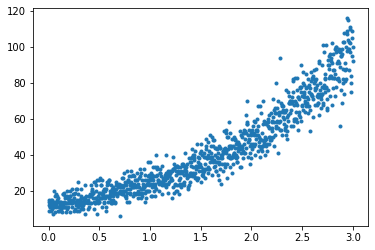

In [4]:
plt.plot(X[:, 1], y, '.')

## Estimate parameters
- Write up the log-likelihood function.
- Compute the gradient and Hessian.
- Optimise the log-likelihood function.

In [5]:
def log_likelihood_function(beta, X, y):
    mu = np.exp(np.dot(X, beta))
    return(np.sum(y*np.log(mu) - mu - np.log(factorial(y))))

# For the (extremely) lazy one
def log_likelihood_function_lazy(beta, X, y):
    mu = np.exp(np.dot(X, beta))
    return(np.sum(autograd_sps.poisson.logpmf(y, mu)))

# Test evaluating the function at true_params:
print(log_likelihood_function(true_params, X, y))
print(log_likelihood_function(0.1*true_params, X, y)) # should be much smaller

print(log_likelihood_function_lazy(true_params, X, y))
print(log_likelihood_function_lazy(0.1*true_params, X, y)) # should be much smaller


-3196.612577757235
-108297.42917675708
-3196.6125777572356
-108297.42917675708


## This is literally all we need to do!

In [6]:
# Compute gradient and Hessian by automatic differentiation:
grad_beta = grad(log_likelihood_function, 0)
Hess_beta = hessian(log_likelihood_function, 0)

## Gradient Ascent method with fixed step-size

In [7]:
# Gradient ascent method. Go in the direction of the gradient
beta_old = np.zeros(2)
gamma = 0.000001  # Step size multiplier
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations
   
for i in range(max_iters):
    beta_new = beta_old + gamma * grad_beta(beta_old, X, y)
    step = beta_new - beta_old
    if np.linalg.norm(step) <= precision:
        break
    beta_old = beta_new

if i == (max_iters - 1):
    print("Careful as optimiser has not met termination criteria")
else:   
    print("Maximum achieved in %s iterations" % (i+1))   
    print("Maximum Likelihood Estimator", beta_new)
    print("Variance covariance matrix")
    print(-np.linalg.inv(Hess_beta(beta_new, X, y)))
    print("True parameters", true_params)

Maximum achieved in 1590 iterations
Maximum Likelihood Estimator [2.4987868  0.69896806]
Variance covariance matrix
[[ 1.80543122e-04 -7.85883096e-05]
 [-7.85883096e-05  3.94846787e-05]]
True parameters [2.5 0.7]


## Newton's method. Much faster!

In [8]:
# Alternative (faster) optimiser using Newton-Raphson. Adaptive (to the curvature of the function) step size multiplier
beta_old = np.zeros(2)
precision = 0.00001  # Desired precision of result
max_iters = 10000  # Maximum number of iterations
   
for i in range(max_iters):
    beta_new = beta_old + np.linalg.solve(-Hess_beta(beta_old, X, y),  grad_beta(beta_old, X, y))
    step = beta_new - beta_old
    if np.linalg.norm(step) <= precision:
        break
    beta_old = beta_new

if i == (max_iters - 1):
    print("Careful as optimiser has not met termination criteria")
else:   
    print("Maximum achieved in %s iterations" % (i+1))   
    print("Maximum Likelihood Estimator", beta_new)
    print("Variance covariance matrix")
    print(-np.linalg.inv(Hess_beta(beta_new, X, y)))
    print("True parameters", true_params)

Maximum achieved in 80 iterations
Maximum Likelihood Estimator [2.50074503 0.69809422]
Variance covariance matrix
[[ 1.80343661e-04 -7.85118181e-05]
 [-7.85118181e-05  3.94568345e-05]]
True parameters [2.5 0.7]


# Just for fun, let's inspect the fit

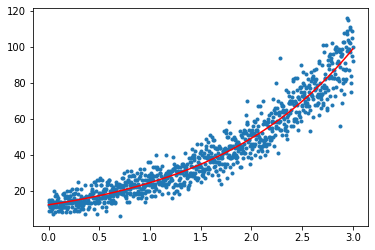

In [9]:
nFit = 100000
Xtilde = np.hstack((np.ones((n, 1)), np.linspace(0, 3, n).reshape(-1, 1)))
y_fit = np.exp(np.dot(X, beta_new))
plt.plot(X[:, 1], y, '.')
plt.plot(Xtilde[:, 1], y_fit, '-', color = 'red')